In [1]:
%load_ext autoreload
%autoreload 2

# Explore the columns of data and find outliers
import pandas as pd
import numpy as np
import os
import datetime
from typing import List, Tuple, Dict, Any, Union, Callable

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles
import pandas as pd
import numpy as np
from scipy.stats import kendalltau, spearmanr

plt.rcParams.update(bundles.beamer_moml())

# Update the font
plt.rcParams["font.family"] = "serif"

# Update the plt savefig path
SAVE_DIR = '../../figures/'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'jpg'
plt.rcParams["savefig.directory"] = SAVE_DIR

In [2]:
REFRESH_DATA = True
CHARTS_PATH = '../../data/charts_processed.csv'
AUDIO_PATH = '../../data/audio_features_processed.csv'


In [3]:
if REFRESH_DATA:

    # Load the datasets into dataframes. Read the date column as datetime.date
    charts_df = pd.read_csv(CHARTS_PATH, parse_dates=['date'])

charts_df['date'] = pd.to_datetime(charts_df['date'])

# Display the first few rows of the DataFrame to verify
charts_df.head()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0


In [4]:
if REFRESH_DATA:
    # Load the audio features dataset
    audio_df = pd.read_csv(AUDIO_PATH)

    # Change the column-name of 'id' to 'track_id' to match the charts_df
    audio_df.rename(columns={'id': 'track_id'}, inplace=True)
    print(audio_df.head())


   acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0       0.18700         0.852       195840   0.773          0.000030    8   
1       0.00431         0.663       259196   0.920          0.000017   11   
2       0.40000         0.761       222560   0.838          0.000000    4   
3       0.55100         0.508       205600   0.687          0.000003    0   
4       0.07600         0.899       234320   0.626          0.000000    6   

   liveness  loudness  mode  speechiness    tempo  time_signature  valence  \
0    0.1590    -2.921     0       0.0776  102.034               4    0.907   
1    0.1010    -4.070     0       0.2260   99.935               4    0.533   
2    0.1760    -3.073     0       0.0502   93.974               4    0.710   
3    0.1260    -4.361     1       0.3260  180.044               4    0.555   
4    0.0631    -4.228     0       0.2920   88.007               4    0.873   

                 track_id  
0  6mICuAdrwEjh6Y6lroV2Kg  
1  7DM4BPaS7

In [5]:
# For now only restrict the dataset to top200 charts for stream/ranking analysis.
charts_df = charts_df[charts_df["chart"] == "top200"]
charts_df["track_id"] = charts_df["url"].apply(lambda x: x.split("/")[-1])

## Topic : Regional Correlations
In the previous notebook, a popularity metric is defined for a track and we explored the correlation between audio features and the songs. This notebook investigates and considers every regions popularity correlations with their top songs. 


In [10]:
import sys
sys.path.append("..")
from utils.regions import get_regional_charts_delta_rank, get_charts_by_region,calculate_popularity_metrics
from scipy.stats import kendalltau, spearmanr, pearsonr
def get_region_correlations(region : str,
                            date : Union[str, Tuple[str,str]],
                            charts_df : pd.DataFrame,
                            audio_df : pd.DataFrame,
                            delta_k = 200,
                            correlation_column : str = 'weighted_popularity'
                            ) -> pd.DataFrame:
    """
    Get the correlation between the audio features and the chart position for a given region.
    """
    test_df = calculate_popularity_metrics(
        charts_df,
        region,
        date,
        delta_k = delta_k,
    )

    test_df['weighted_popularity'] = test_df['popularity'] * test_df['average_stream_proportion']
    test_df_joined = test_df[['track_id',correlation_column]].join(audio_df.set_index('track_id'), on='track_id').drop_duplicates(subset="track_id")

    # Get the correliatons usning scipy
    corr_dict = {}
    spearman_corr_dict = {}
    kendal_corr_dict = {}
    for col in audio_df.columns:
        if col == 'track_id':
            continue
        corr = pearsonr(test_df_joined[correlation_column], test_df_joined[col])
        spearman_corr = spearmanr(test_df_joined[correlation_column], test_df_joined[col])
        kendal_corr = kendalltau(test_df_joined[correlation_column], test_df_joined[col])

        corr_dict[col] = corr
        spearman_corr_dict[col] = spearman_corr
        kendal_corr_dict[col] = kendal_corr

    # Make the values of dict Series to be compatible
    corr_dict = pd.DataFrame(corr_dict, index=['corr', 'p-value']).T
    spearman_corr_dict = pd.DataFrame(spearman_corr_dict, index=['corr', 'p-value']).T
    kendal_corr_dict = pd.DataFrame(kendal_corr_dict, index=['corr', 'p-value']).T
    
    return corr_dict, spearman_corr_dict, kendal_corr_dict

delta_k = 200
COI = "weighted_popularity"
corrs_dict = {}
for unique_region in charts_df['region'].unique():
    corrs = get_region_correlations(unique_region,
                                    ("2017-01-01", "2022-01-01"),
                                    charts_df, audio_df,
                                    delta_k = delta_k,
                                    correlation_column = COI)
    # Save it to a dictionary
    corrs_dict[unique_region] = corrs


Calculating metrics for Argentina between 2017-01-01 and 2022-01-01: 100%|██████████| 4107/4107 [01:23<00:00, 49.39it/s]
Calculating metrics for Australia between 2017-01-01 and 2022-01-01: 100%|██████████| 5520/5520 [01:52<00:00, 49.00it/s]
Calculating metrics for Brazil between 2017-01-01 and 2022-01-01: 100%|██████████| 4797/4797 [01:38<00:00, 48.80it/s]
Calculating metrics for Austria between 2017-01-01 and 2022-01-01: 100%|██████████| 8988/8988 [03:03<00:00, 48.97it/s]
Calculating metrics for Belgium between 2017-01-01 and 2022-01-01: 100%|██████████| 8083/8083 [02:41<00:00, 50.07it/s]
Calculating metrics for Colombia between 2017-01-01 and 2022-01-01: 100%|██████████| 4319/4319 [01:27<00:00, 49.12it/s]
Calculating metrics for Bolivia between 2017-01-01 and 2022-01-01: 100%|██████████| 3341/3341 [00:59<00:00, 55.70it/s]
Calculating metrics for Denmark between 2017-01-01 and 2022-01-01: 100%|██████████| 7086/7086 [02:23<00:00, 49.36it/s]
Calculating metrics for Bulgaria between 201

In [ ]:
# Save the dictionary to a pickle file
import pickle
with open(f'correlations_2017_2022_{COI}.pickle', 'wb') as handle:
    pickle.dump(corrs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


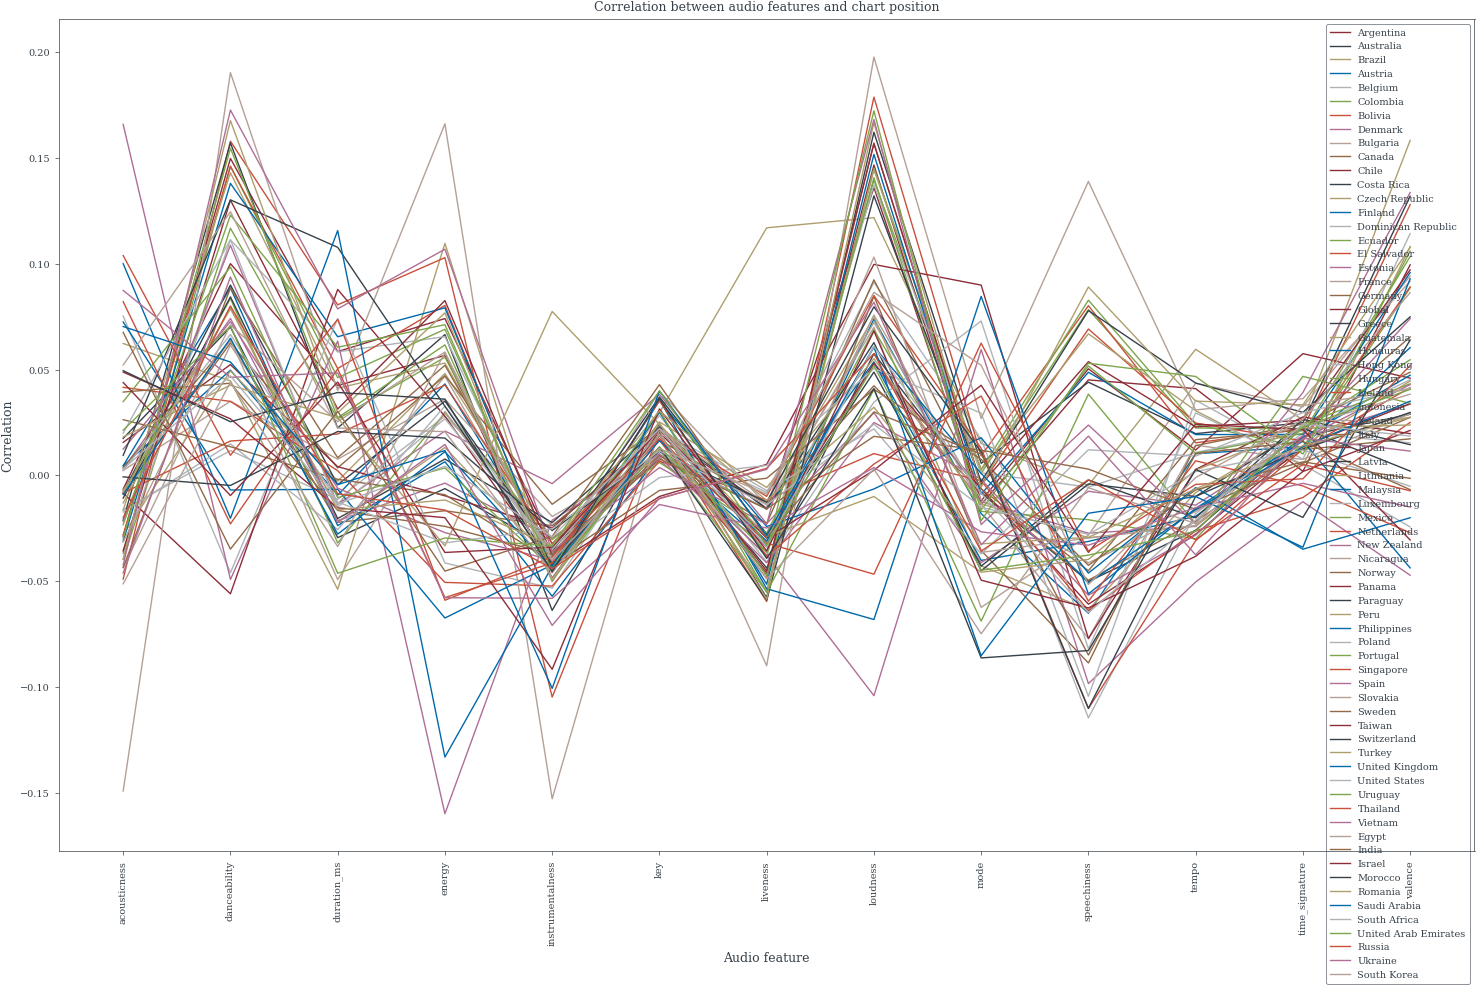

In [33]:
# Plot the every region's correlation with the audio features
plt.figure(figsize=(15, 10))
for region, corr in corrs_dict.items():
    plt.plot(corr[0][1:], label=region)
    plt.legend()
    plt.xticks(rotation=90)
    plt.title("Correlation between audio features and chart position")
    plt.ylabel("Correlation")
    plt.xlabel("Audio feature")
    plt.tight_layout()

plt.savefig(os.path.join(SAVE_DIR, f"correlation_top_{delta_k}.jpg"))
plt.show()

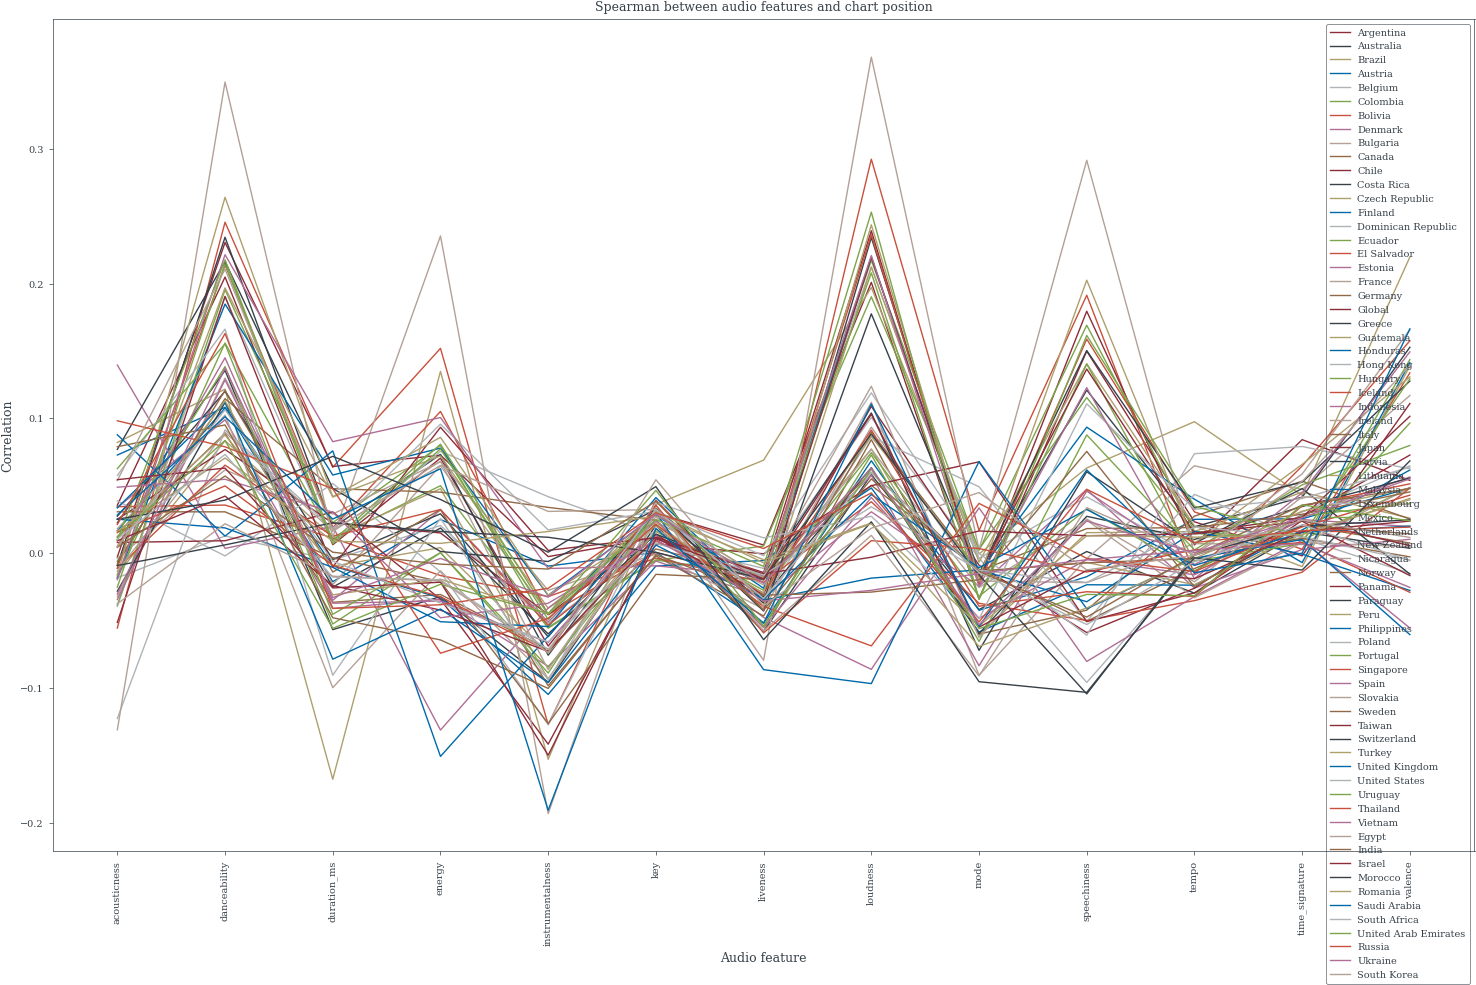

In [34]:
# Plot the every region's correlation with the audio features
plt.figure(figsize=(15, 10))
for region, corr in corrs_dict.items():
    plt.plot(corr[1][1:], label=region)
    plt.legend()
    plt.xticks(rotation=90)
    plt.title("Spearman between audio features and chart position")
    plt.ylabel("Correlation")
    plt.xlabel("Audio feature")
    plt.tight_layout()

plt.savefig(os.path.join(SAVE_DIR, f"spearman_correlation_top_{delta_k}.jpg"))
plt.show()

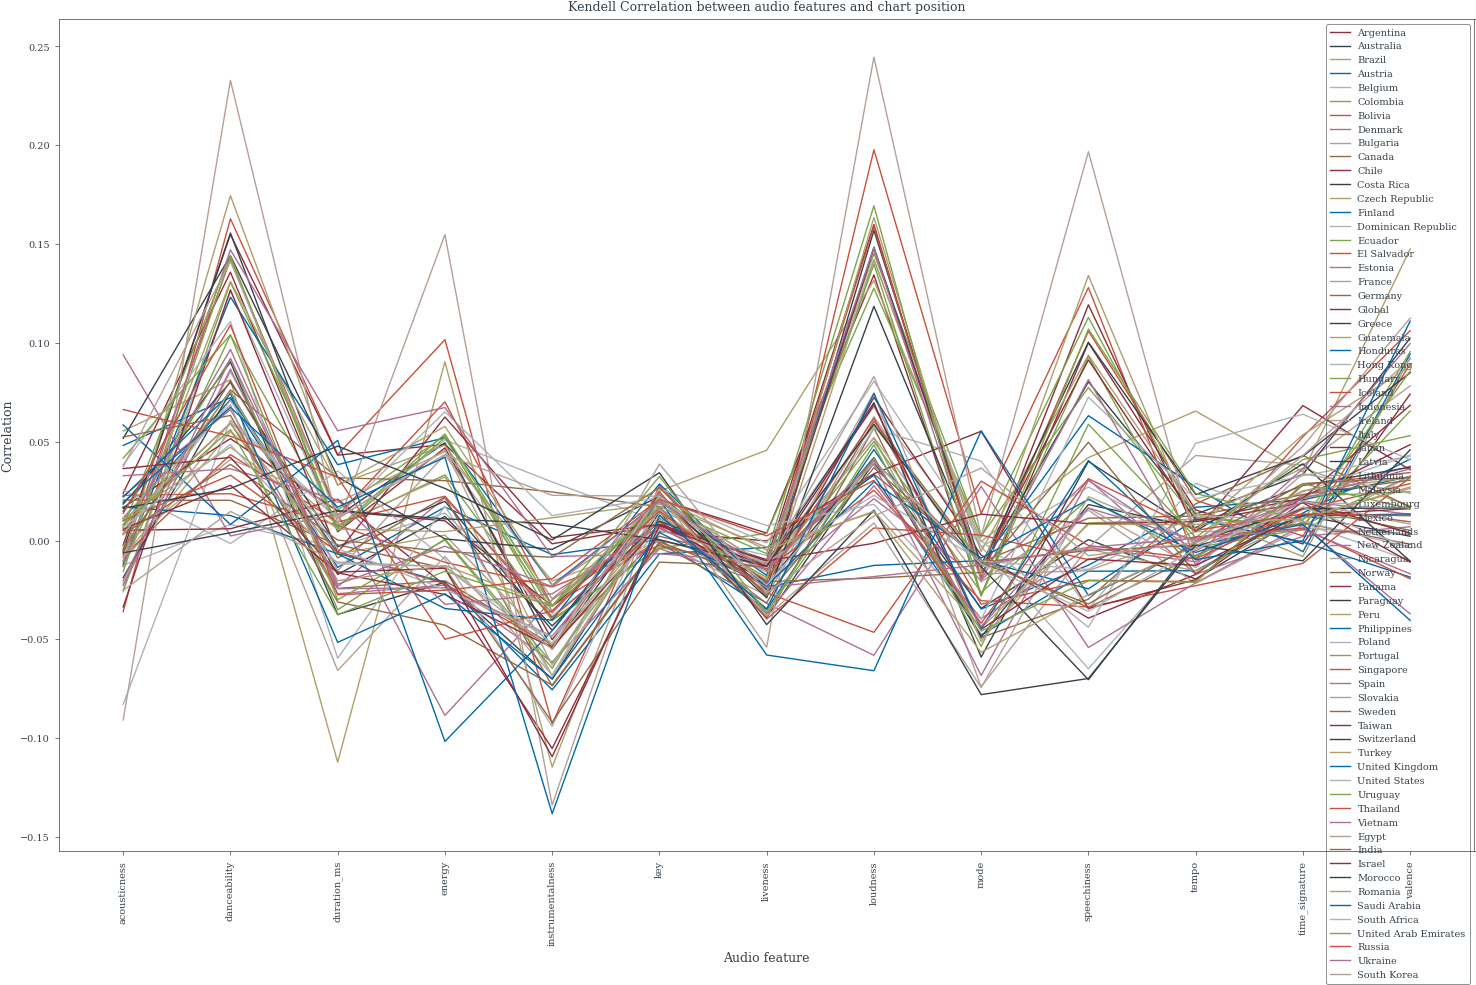

In [35]:
# Plot the every region's correlation with the audio features
plt.figure(figsize=(15, 10))
for region, corr in corrs_dict.items():
    plt.plot(corr[2][1:], label=region)
    plt.legend()
    plt.xticks(rotation=90)
    plt.title("Kendell Correlation between audio features and chart position")
    plt.ylabel("Correlation")
    plt.xlabel("Audio feature")
    plt.tight_layout()

plt.savefig(os.path.join(SAVE_DIR, f"kendell_correlation_top_{delta_k}.jpg"))
plt.show()

In [51]:
# Transform the dictionary into a dataframe
default_corrs_dict = {k:v[0] for k,v in corrs_dict.items()}
spearmans_corrs_dict = {k:v[1] for k,v in corrs_dict.items()}
kendell_corrs_dict = {k:v[2] for k,v in corrs_dict.items()}

default_corrs_df = pd.concat(default_corrs_dict, axis=1)
spearmans_corrs_df = pd.concat(spearmans_corrs_dict, axis=1)
kendell_corrs_df = pd.concat(kendell_corrs_dict, axis=1)

# Swap the columns and rows
default_corrs_df = default_corrs_df.T
spearmans_corrs_df = spearmans_corrs_df.T
kendell_corrs_df = kendell_corrs_df.T

# Concat by columns with prefix by adding _s to spearmans and _k to kendell
spearmans_corrs_df.columns = [f"{col}_s" for col in spearmans_corrs_df.columns]
kendell_corrs_df.columns = [f"{col}_k" for col in kendell_corrs_df.columns]
corrs_df = pd.concat([default_corrs_df, spearmans_corrs_df, kendell_corrs_df], axis=1)

# Print the max and min correlations with their regions
for col in corrs_df.columns:
    print(f"Max correlation for {col} is {corrs_df[col].max()} with {corrs_df[col].idxmax()}")
    print(f"Min correlation for {col} is {corrs_df[col].min()} with {corrs_df[col].idxmin()}")

Max correlation for weighted_popularity is 1.0 with Argentina
Min correlation for weighted_popularity is 1.0 with Argentina
Max correlation for acousticness is 0.16584923032033036 with Indonesia
Min correlation for acousticness is -0.14916785172881455 with Nicaragua
Max correlation for danceability is 0.19033732011527343 with Nicaragua
Min correlation for danceability is -0.05595042119018883 with Japan
Max correlation for duration_ms is 0.11571373631033653 with Philippines
Min correlation for duration_ms is -0.053818923833033785 with Brazil
Max correlation for energy is 0.16615346201451237 with Nicaragua
Min correlation for energy is -0.1598600279397077 with Indonesia
Max correlation for instrumentalness is 0.07745326853480744 with Turkey
Min correlation for instrumentalness is -0.15281231017375702 with Nicaragua
Max correlation for key is 0.04287583301572252 with India
Min correlation for key is -0.013744105795368456 with Vietnam
Max correlation for liveness is 0.11700030853831696 wit

# Topic 2 : Monthly Analysis
In this section, we will investigate popularity with respect to different time ranges. In this way, we will see how popularity of a track within month relates to the audio features.

In [67]:
from utils.regions import calculate_popularity_metrics_weekly
def get_region_correlations_weekly(region : str,
                            date : Union[str, Tuple[str,str]],
                            charts_df : pd.DataFrame,
                            audio_df : pd.DataFrame,
                            delta_t : int = 30,
                            delta_k = 200
                            ) -> pd.DataFrame:
    """
    Get the correlation between the audio features and the chart position for a given region.
    """
    corr_list_dict = {}
    spearman_corr_list_dict = {}
    kendell_corr_list_dict = {}
    test_df_dict = calculate_popularity_metrics_weekly(
        charts_df,
        region,
        date,
        delta_k = delta_k,
        delta_t=delta_t
    )
    for test_df in test_df_dict.values():
        corr_list = []
        spearman_corr_list = []
        kendell_corr_list = []
        test_df['weighted_popularity'] = test_df['popularity'] * test_df['average_stream_proportion']
        corr = test_df[['track_id','weighted_popularity']].join(audio_df.set_index('track_id'), on='track_id').drop_duplicates(subset="track_id").corr()
        spearman_corr = test_df[['track_id','weighted_popularity']].join(audio_df.set_index('track_id'), on='track_id').drop_duplicates(subset="track_id").corr(method='spearman')
        kendal_corr = test_df[['track_id','weighted_popularity']].join(audio_df.set_index('track_id'), on='track_id').drop_duplicates(subset="track_id").corr(method='kendall')

        # Only take the weighted popularity and audio features
        corr = corr.loc['weighted_popularity', :]
        spearman_corr = spearman_corr.loc['weighted_popularity', :]
        kendal_corr = kendal_corr.loc['weighted_popularity', :]

        corr_list.append(corr)
        spearman_corr_list.append(spearman_corr)
        kendell_corr_list.append(kendal_corr)

        if not test_df.empty:
            corr_list_dict[test_df['date'].iloc[0]] = pd.concat(corr_list)
            spearman_corr_list_dict[test_df['date'].iloc[0]] = pd.concat(spearman_corr_list)
            kendell_corr_list_dict[test_df['date'].iloc[0]] = pd.concat(kendell_corr_list)

    return corr_list_dict, spearman_corr_list_dict, kendell_corr_list_dict

corrs_monthly_dict = {}
for unique_region in charts_df['region'].unique():
    corrs = get_region_correlations_weekly(unique_region, ("2017-01-01", "2022-01-01"), charts_df, audio_df, delta_t = 365)
    # Save it to a dictionary
    corrs_monthly_dict[unique_region] = corrs

# Save the dictionary to a pickle file
with open(f'correlations_2017_2022_yearly.pickle', 'wb') as handle:
    pickle.dump(corrs_monthly_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Calculating metrics for Argentina between 2017-01-01 00:00:00 and 2018-01-01 00:00:00: 100%|██████████| 973/973 [00:04<00:00, 225.43it/s]
Calculating metrics for Argentina between 2018-01-01 00:00:00 and 2019-01-01 00:00:00: 100%|██████████| 1147/1147 [00:05<00:00, 218.64it/s]
Calculating metrics for Argentina between 2019-01-01 00:00:00 and 2020-01-01 00:00:00: 100%|██████████| 1059/1059 [00:06<00:00, 169.21it/s]
Calculating metrics for Argentina between 2020-01-01 00:00:00 and 2021-01-01 00:00:00: 100%|██████████| 1168/1168 [00:05<00:00, 207.98it/s]
Calculating metrics for Argentina between 2021-01-01 00:00:00 and 2022-01-01 00:00:00: 100%|██████████| 1057/1057 [00:05<00:00, 208.88it/s]
Calculating metrics for Argentina between 2022-01-01 00:00:00 and 2022-01-01 00:00:00: 0it [00:00, ?it/s]
Calculating metrics for Australia between 2017-01-01 00:00:00 and 2018-01-01 00:00:00: 100%|██████████| 1489/1489 [00:07<00:00, 205.04it/s]
Calculating metrics for Australia between 2018-01-01 00:

In [70]:
corrs_monthly_dict["Turkey"]

({Timestamp('2017-01-01 00:00:00'): weighted_popularity    1.000000
  acousticness          -0.022628
  danceability           0.098118
  duration_ms           -0.043428
  energy                 0.043671
  instrumentalness      -0.027410
  key                   -0.033145
  liveness              -0.064742
  loudness               0.103059
  mode                  -0.070453
  speechiness           -0.010231
  tempo                  0.012600
  time_signature         0.040535
  valence                0.111043
  Name: weighted_popularity, dtype: float64,
  Timestamp('2018-03-01 00:00:00'): weighted_popularity    1.000000
  acousticness          -0.033533
  danceability           0.074048
  duration_ms            0.057979
  energy                 0.028595
  instrumentalness       0.047381
  key                    0.025233
  liveness               0.030611
  loudness               0.017875
  mode                  -0.012269
  speechiness            0.012579
  tempo                 -0.011015
  t

In [62]:
charts_df["date"].min(),charts_df["date"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2021-12-31 00:00:00'))